In [1]:
import numpy as np
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.style.use("seaborn")

/home/jo/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Fetch dataset

In [2]:
from SCFInitialGuess.utilities.dataset import make_butadien_dataset, extract_triu

#dim ethen
dim = 26

def load_triu(S, P, dim):
    
    return [extract_triu(s, dim) for s in S], [extract_triu(p, dim) for p in P]

dataset, molecules = make_butadien_dataset(
    np.load("../data/molecules.npy"),
    np.load("../data/S.npy"), 
    np.load("../data/P.npy")
)

[-] 2018-06-01 21:07:20: Data set normalized. Mean value std: 0.008732722987069362


# Fetch network 

In [3]:
from SCFInitialGuess.nn.networks import EluFixedValue

graph = tf.Graph()

structure, weights, biases = np.load("../data/network.npy", encoding="latin1")

with graph.as_default():
    sess = tf.Session()
    network = EluFixedValue(structure, weights, biases)
    network.setup()
    sess.run(tf.global_variables_initializer())

# Create guesses

In [4]:
from SCFInitialGuess.utilities.dataset import make_matrix_batch
from SCFInitialGuess.nn.post_processing import multi_mc_wheeny
from pyscf.scf import hf

s_raw = make_matrix_batch(dataset.inverse_input_transform(dataset.testing[0]), dim, False)

p_nn = network.run(sess, dataset.testing[0])

p_batch = make_matrix_batch(p_nn, dim, False).astype("float64")
p_mcw1 = np.array(list(map(lambda x: multi_mc_wheeny(x[0], x[1], n_max=1), zip(p_batch, s_raw)))).astype("float64")
p_mcw5 = np.array(list(map(lambda x: multi_mc_wheeny(x[0], x[1], n_max=5), zip  (p_batch, s_raw)))).astype("float64")

p_sap = np.array([
    hf.init_guess_by_atom(mol.get_pyscf_molecule()) for mol in molecules[1]
]).astype("float64")
p_minao = np.array([
    hf.init_guess_by_minao(mol.get_pyscf_molecule()) for mol in molecules[1]
]).astype("float64")
p_gwh = np.array([
    hf.init_guess_by_wolfsberg_helmholtz(mol.get_pyscf_molecule()) for mol in molecules[1]
]).astype("float64")

# Measure iterations 

In [20]:
from SCFInitialGuess.utilities.analysis import measure_iterations, mf_initializer

iterations = []

print("nn")
iterations.append(measure_iterations(mf_initializer, p_batch, molecules[1]))
print("mcw1")
iterations.append(measure_iterations(mf_initializer, p_mcw1, molecules[1]))
print("mcw5")
iterations.append(measure_iterations(mf_initializer, p_mcw5, molecules[1]))
print("sap")
iterations.append(measure_iterations(mf_initializer, p_sap, molecules[1]))
print("minao")
iterations.append(measure_iterations(mf_initializer, p_minao, molecules[1]))
print("gwh")
iterations.append(measure_iterations(mf_initializer, p_gwh, molecules[1]))

iterations = np.array(iterations).T
iterations.shape

nn
[ ] 2018-06-01 21:17:32: Iteration calculation: 0
[ ] 2018-06-01 21:17:33: Iteration calculation: 1
[ ] 2018-06-01 21:17:33: Iteration calculation: 2
[ ] 2018-06-01 21:17:33: Iteration calculation: 3
[ ] 2018-06-01 21:17:33: Iteration calculation: 4
[ ] 2018-06-01 21:17:33: Iteration calculation: 5
[ ] 2018-06-01 21:17:33: Iteration calculation: 6
[ ] 2018-06-01 21:17:33: Iteration calculation: 7
[ ] 2018-06-01 21:17:34: Iteration calculation: 8
[ ] 2018-06-01 21:17:34: Iteration calculation: 9
[ ] 2018-06-01 21:17:34: Iteration calculation: 10
[ ] 2018-06-01 21:17:34: Iteration calculation: 11
[ ] 2018-06-01 21:17:34: Iteration calculation: 12
[ ] 2018-06-01 21:17:34: Iteration calculation: 13
[ ] 2018-06-01 21:17:34: Iteration calculation: 14
[ ] 2018-06-01 21:17:34: Iteration calculation: 15
[ ] 2018-06-01 21:17:35: Iteration calculation: 16
[ ] 2018-06-01 21:17:35: Iteration calculation: 17
[ ] 2018-06-01 21:17:35: Iteration calculation: 18
[ ] 2018-06-01 21:17:35: Iteration cal

[ ] 2018-06-01 21:17:55: Iteration calculation: 12
[ ] 2018-06-01 21:17:56: Iteration calculation: 13
[ ] 2018-06-01 21:17:56: Iteration calculation: 14
[ ] 2018-06-01 21:17:56: Iteration calculation: 15
[ ] 2018-06-01 21:17:56: Iteration calculation: 16
[ ] 2018-06-01 21:17:56: Iteration calculation: 17
[ ] 2018-06-01 21:17:57: Iteration calculation: 18
[ ] 2018-06-01 21:17:57: Iteration calculation: 19
[ ] 2018-06-01 21:17:57: Iteration calculation: 20
[ ] 2018-06-01 21:17:57: Iteration calculation: 21
[ ] 2018-06-01 21:17:58: Iteration calculation: 22
[ ] 2018-06-01 21:17:58: Iteration calculation: 23
[ ] 2018-06-01 21:17:58: Iteration calculation: 24
[ ] 2018-06-01 21:17:58: Iteration calculation: 25
[ ] 2018-06-01 21:17:58: Iteration calculation: 26
[ ] 2018-06-01 21:17:59: Iteration calculation: 27
[ ] 2018-06-01 21:17:59: Iteration calculation: 28
[ ] 2018-06-01 21:17:59: Iteration calculation: 29
[ ] 2018-06-01 21:17:59: Iteration calculation: 30
[ ] 2018-06-01 21:18:00: Iterat

(50, 6)

In [17]:
median = np.median(iterations[:, 1])

lower_quartile = iterations[:, 1][iterations[:, 1] < median]
upper_quartile = iterations[:, 1][iterations[:, 1] > median]
np.median(lower_quartile), median, np.median(upper_quartile)

(7.0, 8.0, 10.0)

# Plot 

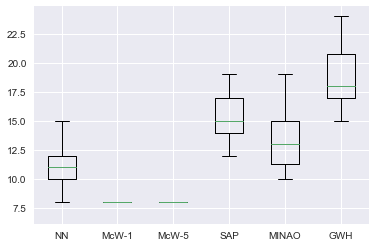

In [19]:
labels = ["NN", "McW-1", "McW-5", "SAP", "MINAO", "GWH"]

plt.boxplot(iterations)
plt.xticks(np.arange(1, 7), labels)
plt.show()

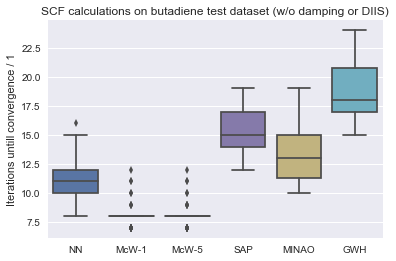

In [30]:
from pandas import DataFrame
from seaborn import boxplot

#frame = DataFrame([[iterations[:,i] for i in range(len(labels))]], columns=labels)
frame = DataFrame(iterations, columns=labels)
boxplot(data=iterations)
plt.xticks(np.arange(6), labels)
plt.ylabel("Iterations untill convergence / 1")
plt.title("SCF calculations on butadiene test dataset (w/o damping or DIIS)")
plt.savefig("/home/jo/Repos/cc2aiPoster/figures/iterationsBoxPlot.pdf")
plt.show()

# Subplot

In [ ]:
def add_plot(ax, title, data):
    
    ax.boxplot(data)
    ax.set_title(title)
    ax.set_ylabel("Iterations / 1")
    
    
    
data = np.random.rand(100, 6)
    
fig, axes = plt.subplots(3, 1)
titles = ["Plain", "Damped", "DIIS"]
for i in range(len(axes)):
    add_plot(axes[i], titles[i], data)
    
axes[-1].set_xticklabels(labels)

In [ ]:
import seaborn as sns


data = np.random.rand(100, 6)
"""
data={
        "NN": iterations[:,0],
        "McW-1": iterations[:,1],
        "McW-5": iterations[:,2]
    }
#"""

sns.boxplot(
    list(data.T),
    orient="v"
)

plt.show()

In [ ]:
list(data.T)